# Data Wrangling
In this notebook we'll obtain all of our data, arrange it how we want, and store it in the proper directories.

In [27]:
%run 0_1_setup.ipynb
import copernicusmarine

# Establish a tide gauge data directory to store the station netcdf files. 
# This will be important for the NOAA data, since we'll be pinging the API a lot (due to time range limits), 
# and we don't want to do that every time we run the notebook.

tg_nc_dir = data_dir / 'tide_gauge_nc'

# Check if the directories exist, if not create them
for d in [data_dir, output_dir, tg_nc_dir]:
    if not d.exists():
        d.mkdir()

# make a climate_indices directory if it doesn't exist
climate_indices_dir = data_dir / 'climate_indices'
if not climate_indices_dir.exists():
    climate_indices_dir.mkdir()        

Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output


## Retrieve Tide Gauge Data

We are interested in getting tide gauge and alitmetry data for the Hawaiian Islands (and surrounds) for 1993 through 2022.
Let's first establish where the tide gauges are by looking at the tide gauge dataset. We'll retrieve tide gauge data from the UHSLC (University of Hawaii Sea Level Center) fast-delivery dataset {cite:p}`patrick_c_caldwell_sea_2015`. The fast-delivery data are released within 1-2 months of data collection and are subject only to basic quality control. Fast-delivery hourly data are averaged (or smoothed) quantities, via a Bloomfield convolution-type filter centered on each hour of higher-frequency data. Research quality data is back-filled into the fast-delivery dataset once updated values are available.

We'll be retrieving the hourly data for our station group at from UHSLC, and saving this to our data directory.

In [28]:
# hawaii stations are: 
stationdict = {
    'Hilo': '060',
    'Kawaihae': '552',
    'Kahului': '059',
    'Mokuoloe': '061',
    'Honolulu': '057',
    'Nawiliwili': '058',
    'Johnston Island': '052',
    'Midway Island': '050',
    'Kaumalapau': '548',
    'Barbers Point': '547',
    'French Frigate Shoals': '014',
}
stationdict.values()

station_group = 'Hawaiian Islands'

glue('station_group', station_group)

'Hawaiian Islands'

````{margin}
```{note}
What about research quality data (RQD)? 
RQD undergo thorough and time-consuming QC, and are usually released 1-2 years after data is received. 
```
````

Instead of downloading each gauge's data and saving them as a netcdf file we'll just merge all the datasets right away. This can take a while.

In [29]:
# Open the datasets
datasets = [xr.open_dataset(f'https://uhslc.soest.hawaii.edu/opendap/fast/daily/d{uh_id}.nc') for uh_id in stationdict.values()]

#merge in batches of 2 to avoid memory issues
batch_size = 2
merged_datasets = []

for i in range(0, len(datasets), batch_size):
    batch = datasets[i:i+batch_size]
    merged_batch = xr.merge(batch, compat='no_conflicts', join='outer')
    merged_datasets.append(merged_batch)

#merge the merged datasets
rsl = xr.merge(merged_datasets, compat='no_conflicts', join='outer')



```{caution}
In the following section I remove the trailing zero from the record-id of each tide gauge. This trailing zero is only on fast-delivery data products.
```

In [30]:
# rename record_id to station_id - this will align with the UH TG set with the coordinate convention in the NOAA set.
rsl = rsl.rename({'record_id': 'station_id'})
# remove the trailing zero from each station_id
rsl['station_id'] =(rsl['station_id']/10).astype(int)

Now we'll close our datasets to free up memory:

In [31]:
# close datasets to free up memory
for ds in datasets:
    ds.close()
for ds in merged_datasets:  
    ds.close()
del datasets
del merged_datasets

and manage some formatting issues in the combined netcdf file.

In [32]:
# convert byte strings to normal strings
rsl['station_name'] = xr.DataArray(
    np.array(rsl['station_name'].values, dtype='U50'),
    dims=('station_id',)
)
rsl['station_country'] = xr.DataArray(
    np.array(rsl['station_country'].values, dtype='U30'),
    dims=('station_id',)
)
rsl['ssc_id'] = xr.DataArray(
    np.array(rsl['ssc_id'].values, dtype='U30'),
    dims=('station_id',)
)

# set uh_id and gloss_id to integers
rsl['uhslc_id'] = rsl['uhslc_id'].astype(int)

# some of the stations don't have a gloss_id so we need to handle that
# Replace empty byte strings with NaN, then fill NaN with a placeholder, then cast to int
rsl['gloss_id'] = rsl['gloss_id'].where(rsl['gloss_id'] != b'').fillna(-9999).astype(int)


rsl

<xarray.Dataset> Size: 2MB
Dimensions:               (time: 44133, station_id: 11)
Coordinates:
  * time                  (time) datetime64[ns] 353kB 1905-01-02T12:00:00 ......
  * station_id            (station_id) int64 88B 14 50 52 57 ... 61 547 548 552
Data variables:
    station_name          (station_id) <U50 2kB 'French Frigate' ... 'Kawaihae'
    station_country       (station_id) <U30 1kB 'United States of America (th...
    ssc_id                (station_id) <U30 1kB 'fren' 'midx' ... 'kaum' 'kawa'
    sea_level             (station_id, time) float32 2MB nan nan ... 1.292e+03
    lat                   (station_id) float32 44B 23.87 28.22 ... 20.78 20.03
    lon                   (station_id) float32 44B 193.7 182.6 ... 203.0 204.2
    station_country_code  (station_id) float32 44B 840.0 840.0 ... 840.0 840.0
    uhslc_id              (station_id) int64 88B 14 50 52 57 ... 61 547 548 552
    gloss_id              (station_id) int64 88B 107 106 109 ... -9999 -9999
    last_rq_date          (station_id) datetime64[ns] 88B 2018-10-03T12:00:00...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (daily)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-01T14:26:56Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

The following function will extract a given datum for a UHSLC gauge from the UHSLC site.

In [33]:
def get_MHHW_uhslc_datums(id, datumname, table=None):
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_m_GMT.csv'
    datumtable = pd.read_csv(url)
    datum = datumtable[datumtable['Name'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    if table:
        return datum, datumtable
    else:
        return datum

And now we'll add the datums to our xarray netcdf for easy access.

In [34]:
# add MHHW to the dataset
rsl['MHHW'] = xr.DataArray([get_MHHW_uhslc_datums(id, 'MHHW') for id in rsl['uhslc_id'].values], dims='station_id', coords={'station_id': rsl['station_id']})

rsl['MHHW'].attrs['units'] = 'm'
rsl['MHHW'].attrs['long_name'] = 'Mean Higher High Water, rel. to station datum'

glue('datumname', 'MHHW')

# add MSL to the dataset
rsl['MSL'] = xr.DataArray([get_MHHW_uhslc_datums(id, 'MSL') for id in rsl['uhslc_id'].values], dims='station_id', coords={'station_id': rsl['station_id']})

rsl['MSL'].attrs['units'] = 'm'
rsl['MSL'].attrs['long_name'] = 'Mean Sea Level, rel. to station datum'

# add MSL to the dataset
rsl['MLLW'] = xr.DataArray([get_MHHW_uhslc_datums(id, 'MLLW') for id in rsl['uhslc_id'].values], dims='station_id', coords={'station_id': rsl['station_id']})

rsl['MLLW'].attrs['units'] = 'm'
rsl['MLLW'].attrs['long_name'] = 'Mean Low Low Water, rel. to station datum'



'MHHW'

In some cases, not all times are on the hour from UHSLC. They are not off by that much, though, so we can just round our data to the hour. 

In [35]:
#round the time to the nearest hour
rsl['time'] = rsl['time'].dt.round('h')

UHSLC also delivers data in millimeters, so we'll convert it to meters to standardize the units.

In [36]:
#convert sea level variable to m
rsl['sea_level'] = rsl['sea_level'] / 1000  # convert from mm to m
rsl['sea_level'].attrs['units'] = 'm'

Now we'll save it to our data directory.

In [37]:
#ensure rsl is netcdf4 format
rsl.to_netcdf(data_dir / 'rsl_hawaii_uhslc.nc',engine='netcdf4',mode='w')

rsl.close()



## Retrieve data from NOAA CO-OPS API

Next we'll get the data from NOAA CO-OPS API. Depending on the type of data to be accessed, there can be limits on how much data can be downloaded in one go. So if we want the entire timeseries, we must fetch the data in chunks. We'll first figure out what NOAA stations there are in the Hawaii set we just got from UHSLC, and then we'll grab our chunked data and turn it into netcdf files (one per station) to save in our data directory.


In [38]:
import json
url = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations.json"

response = requests.get(url)

# get a list of all the stations
stations = json.loads(response.text)

#from list of stations, get NOAA stations within the bounding box of UHSLC gauges
hawaii_stations = [station for station in stations['stations'] if station['lat'] >= rsl['lat'].min()-2 and station['lat'] <= rsl['lat'].max()+2 and station['lng'] >= -(360-rsl['lon'].min())-2 and station['lng'] <= -(360-rsl['lon'].max())+2]

#make a dictionary of all stations in hawaii with station name: station id
stationdictNOAA  = {station['name']: station['id'] for station in hawaii_stations}
stationdictNOAA 

# remove Pearl Harbor gauge  - tidesandcurrents lists the station that started in 2023, and we're not here to combine data.
stationdictNOAA.pop('Pearl Harbor', None)

stationdictNOAA


{'Nawiliwili': '1611400',
 'Honolulu': '1612340',
 'Mokuoloe': '1612480',
 'Kahului, Kahului Harbor': '1615680',
 'Kawaihae': '1617433',
 'Hilo, Hilo Bay, Kuhio Bay': '1617760',
 'Sand Island, Midway Islands': '1619910'}

```{admonition} Let's talk about what Hourly means
:class: hint
Below, we'll be downloading the 'hourly height' product from the NOAA CO-OPS API. Fun fact, there are slight differences between what "hourly" means between the UHSLC hourly data and the NOAA hourly data. NOAA's hourly data is the instantaneous 6-min averaged value at the top of each hour, whereas UHSLC's fast-delivery hourly data is the filtered hourly value (see notes from above). What does this mean in practice? NOAA's values will be _slightly_ noisier due to the sampling scheme, but are in keeping with historical tide measurements. It also might mean that if you're looking at extremes or rankings of high water levels, you might miss some of the larger sub-hourly levels. This conundrum is common to any sampling scheme design -- you just have to pick something and stick with it. Ideally, you'd stick with 6-min data for extremes and rankings, but for many NOAA stations the 6-min data does not exist prior to 1996. Alternatively, you could use the 6-min data, and filter it to match the UHSLC sampling scheme. Here, we'll use the hourly height product and stick with it for the rest of the notebooks. 
```

In [39]:
# ...existing code...
import time
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import requests
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta      
from concurrent.futures import ThreadPoolExecutor, as_completed  


def station_por(station_id):
    url = f"https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/{station_id}.json"
    try:
        resp = requests.get(url, timeout=20)
        resp.raise_for_status()
        j = resp.json()
        hist = j.get("stations", [{}])[0].get("historic", [])
        starts, ends = [], []
        for h in hist:
            prods = h.get("products", [])
            if ("water_level" in prods) or ("hourly_height" in prods):
                if h.get("from") and h.get("to"):
                    starts.append(pd.to_datetime(h["from"]))
                    ends.append(pd.to_datetime(h["to"]))
        if starts and ends:
            por_start = min(starts)
            por_end = max(ends)
        else:
            # fallback to top-level
            s0 = j["stations"][0].get("from")
            e0 = j["stations"][0].get("to")
            if s0 and e0:
                por_start = pd.to_datetime(s0)
                por_end = pd.to_datetime(e0)
            else:
                raise ValueError("No POR info")
        return por_start.strftime("%Y%m%d %H:%M"), por_end.strftime("%Y%m%d %H:%M")
    except:
        return '19930101 00:00', datetime.utcnow().strftime('%Y%m%d 00:00')

def fetch_noaa_water_level_parallel(stationID, start_date, end_date, product='hourly_height'):
    start_dt = datetime.strptime(start_date, '%Y%m%d %H:%M')
    end_dt = datetime.strptime(end_date, '%Y%m%d %H:%M')

    # Safety: cap to station POR
    por_s, por_e = station_por(stationID)
    start_dt = max(start_dt, datetime.strptime(por_s, '%Y%m%d %H:%M'))
    end_dt = min(end_dt, datetime.strptime(por_e, '%Y%m%d %H:%M'))

    chunk_days = 30
    date_ranges = []
    cur = start_dt
    while cur < end_dt:
        nxt = min(cur + timedelta(days=chunk_days), end_dt)
        date_ranges.append((cur, nxt))
        cur = nxt + timedelta(seconds=1)

    all_data = []
    max_workers = min(4, len(date_ranges))   # lower concurrency for reliability
    empty_streak = 0
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(fetch_data_chunk, stationID, s, e, product) for s, e in date_ranges]
        for f in as_completed(futures):
            chunk = f.result()
            if chunk:
                all_data.extend(chunk)
                empty_streak = 0
            else:
                empty_streak += 1
                time.sleep(0.2)
                # If too many empty chunks in a row, abort to avoid endless pinging
                if empty_streak >= 20:
                    break

    df = pd.DataFrame(all_data)
    if df.empty:
        print(f"No data fetched for station {stationID}.")
        return xr.Dataset()

    df['t'] = pd.to_datetime(df['t'])
    df = df[df['v'].str.strip() != '']
    df['v'] = df['v'].astype(float)
    df = df.drop_duplicates(subset='t').sort_values('t')

    ts = pd.Series(df['v'].values, index=df['t'])
    ts.index = ts.index.round('h')
    ts = ts.resample('h').mean()
    ts = ts[~ts.index.duplicated(keep='first')]

    ds = xr.Dataset({'sea_level': ('t', ts.values)}, coords={'t': ts.index})
    ds = ds.rename({'t': 'time'})
    return ds




def _requests_session():
    retry = Retry(
        total=5,
        connect=5,
        read=5,
        backoff_factor=1.0,               # exponential backoff: 1, 2, 4, ...
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"]
    )
    s = requests.Session()
    s.mount("https://", HTTPAdapter(max_retries=retry))
    return s

def fetch_data_chunk(stationID, start_date, end_date, product='hourly_height'):
    session = _requests_session()
    begin_date_str = start_date.strftime('%Y%m%d %H:%M')
    end_date_str = end_date.strftime('%Y%m%d %H:%M')
    server = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
    url = (
        f'{server}begin_date={begin_date_str}&end_date={end_date_str}'
        f'&station={stationID}&datum=STND&product={product}&units=metric'
        f'&time_zone=gmt&format=json'
    )

    try:
        resp = session.get(url, timeout=30)
        # small sleep to be polite
        time.sleep(2)
        resp.raise_for_status()
        data = resp.json()
        return data.get('data', [])
    except Exception as e:
        # optional: log e
        return []



In [40]:
stationdictNOAA.items()

dict_items([('Nawiliwili', '1611400'), ('Honolulu', '1612340'), ('Mokuoloe', '1612480'), ('Kahului, Kahului Harbor', '1615680'), ('Kawaihae', '1617433'), ('Hilo, Hilo Bay, Kuhio Bay', '1617760'), ('Sand Island, Midway Islands', '1619910')])

In [41]:
from datetime import datetime
start_date = '19050101 00:00'
end_date = '20241231 00:00'

for station_name, station_id in stationdictNOAA.items():

    start_date_new = None
    target_path = data_dir / f'tide_gauge_nc/noaa_{station_id}.nc'

    if os.path.exists(target_path):
        with xr.open_dataset(target_path) as dsOLD:
            last_date = pd.to_datetime(dsOLD['time'].values[-1])
        if last_date >= datetime.strptime(end_date, '%Y%m%d %H:%M'):
            print(f"{station_name} up to date, skipping")
            continue
        start_date_new = (last_date + timedelta(hours=1)).strftime('%Y%m%d %H:%M')
        print(f"{station_name}: appending from {start_date_new}")
    else:
        print(f"Fetching data for {station_name}")

    fetch_start = start_date_new or start_date
    ds = fetch_noaa_water_level_parallel(station_id, fetch_start, end_date)

    if ds.get('time', xr.DataArray([])).size == 0:
        print(f"No new data for {station_name}, skip write.")
        continue
    
    ds['station_id'] = station_id
    ds['station_name'] = station_name
    ds['station_country'] = 'USA'
    ds['lat'] = float([station['lat'] for station in hawaii_stations if station['id'] == station_id][0])
    ds['lon'] = float([station['lng'] for station in hawaii_stations if station['id'] == station_id][0])

    # if the file already exists, append the new data
    if os.path.exists(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc'):
       with xr.open_dataset(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc') as dsOLD:
           dsNEW = xr.concat([dsOLD, ds], dim='time', data_vars='minimal', coords='minimal', combine_attrs='override')
       dsNEW = dsNEW.drop_duplicates(dim='time')
       dsNEW.to_netcdf(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc')
    else:
       ds.to_netcdf(data_dir /  f'tide_gauge_nc/noaa_{station_id}.nc')

Nawiliwili up to date, skipping
Honolulu up to date, skipping
Mokuoloe up to date, skipping
Kahului, Kahului Harbor up to date, skipping
Kawaihae up to date, skipping
Hilo, Hilo Bay, Kuhio Bay up to date, skipping
Sand Island, Midway Islands up to date, skipping


As before, we'll combine them into one dataset.

In [42]:
##COMMENTED OUT IF DATA HAS ALREADY BEEN COMBINED< TO FIX LATER
# Load the data

      
# Get a list of all noaa*.nc files in the data directory
files = glob.glob(os.path.join(data_dir,'tide_gauge_nc','noaa*.nc'))

# Open the datasets
datasets = [xr.open_dataset(file) for file in files]
# add the station_id as a coordinate
for ds in datasets:
    # ds = remove_time_dim(ds)
    ds.coords['station_id'] = ds['station_id']
rslNOAA = xr.concat(datasets, dim='station_id',join='outer')

rslNOAA['sea_level'].attrs['units'] = 'm'
rslNOAA['sea_level'].attrs['long_name'] = 'Sea level, relative to station datum'


In [43]:
rslNOAA

<xarray.Dataset> Size: 18MB
Dimensions:          (station_id: 7, time: 280489)
Coordinates:
  * time             (time) datetime64[ns] 2MB 1993-01-01 ... 2024-12-31
  * station_id       (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sea_level        (station_id, time) float64 16MB 1.396 1.39 ... 0.878 0.92
    station_name     (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... '...
    station_country  (station_id) <U3 84B 'USA' 'USA' 'USA' ... 'USA' 'USA'
    lat              (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon              (station_id) float64 56B -155.1 -177.4 ... -157.9 -159.4

Let's add some more metadata to this dataset, including MSL and MHHW datums for each gauge.

In [44]:
MHHW = np.zeros(len(rslNOAA['station_id']))
MSL = np.zeros(len(rslNOAA['station_id']))
MLLW = np.zeros(len(rslNOAA['station_id']))

for i in range(len(rslNOAA['station_id'])):
    url = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/'+ str(rslNOAA['station_id'][i].values) +'/datums.json?units=metric'
    
    response = requests.get(url)
    datums = json.loads(response.text)
    
    def extract_datum_value(data, datum_name):
        # Iterate through the datums list
        for datum in data.get('datums', []):
            # Check if the name matches the desired datum name
            if datum.get('name') == datum_name:
                # Return the value if found
                return datum.get('value')
        # Return None if the datum name is not found
        return None
    
    #extract the MHHW and MSL datums
    MHHW[i] = extract_datum_value(datums, 'MHHW')
    MSL[i] = extract_datum_value(datums, 'MSL')
    MLLW[i] = extract_datum_value(datums, 'MLLW')




In [45]:
rslNOAA['MHHW'] = xr.DataArray(MHHW, dims='station_id', coords={'station_id': rslNOAA['station_id']})
rslNOAA['MHHW'].attrs['units'] = 'm'
rslNOAA['MHHW'].attrs['long_name'] = 'Mean Higher High Water, rel. to station datum'

rslNOAA['MSL'] = xr.DataArray(MSL, dims='station_id', coords={'station_id': rslNOAA['station_id']})
rslNOAA['MSL'].attrs['units'] = 'm'
rslNOAA['MSL'].attrs['long_name'] = 'Mean Sea Level, rel. to station datum'

rslNOAA['MLLW'] = xr.DataArray(MLLW, dims='station_id', coords={'station_id': rslNOAA['station_id']})
rslNOAA['MLLW'].attrs['units'] = 'm'
rslNOAA['MLLW'].attrs['long_name'] = 'Mean Lower Low Water, rel. to station datum'


Change the longitude to match UHSLC 360-degree convention.

In [46]:
rslNOAA['lon'] = rslNOAA['lon'] + 360
rslNOAA

<xarray.Dataset> Size: 18MB
Dimensions:          (station_id: 7, time: 280489)
Coordinates:
  * time             (time) datetime64[ns] 2MB 1993-01-01 ... 2024-12-31
  * station_id       (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sea_level        (station_id, time) float64 16MB 1.396 1.39 ... 0.878 0.92
    station_name     (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... '...
    station_country  (station_id) <U3 84B 'USA' 'USA' 'USA' ... 'USA' 'USA'
    lat              (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon              (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    MHHW             (station_id) float64 56B 1.927 1.206 1.444 ... 1.741 1.255
    MSL              (station_id) float64 56B 1.545 1.02 1.08 ... 1.412 0.949
    MLLW             (station_id) float64 56B 1.196 0.824 0.802 ... 1.161 0.697

In [47]:
#save rsl to the data directory
#explicitly assign U50 to the station_name
rslNOAA['station_name'] = xr.DataArray(
    np.array(rslNOAA['station_name'].values, dtype='U50'),
    dims=('station_id',)
)

rslNOAA.to_netcdf(data_dir / 'rsl_hawaii_noaa.nc')

## Retrieve altimetry data 
We are using the global ocean gridded L4 [Sea Surface Heights and Derived Variables](https://doi.org/10.48670/moi-00148) from Copernicus {cite:p}`cmems_dataset`. 

To download a subset of the global altimetry data, uncomment out the call to get_CMEMS_data and run it in this notebook. To read more about how to download the data from the Copernicus Marine Toolbox (new as of December 2023), visit their  [toolbox introduction](https://help.marine.copernicus.eu/en/articles/7949409-copernicus-marine-toolbox-introduction) page. 

````{margin}
```{note}
You will need a username and password to access the CMEMS (Copernicus Marine Service) data if this is the first time running the client. To register for data access (free), visit the [registration](https://data.marine.copernicus.eu/register) site.  
```
````

```{admonition} Large data download!
:class: warning
Getting errors on the code block below? Remember to uncomment "get_CMEMS_data()" to download. Note that if you change nothing in the function, it will download ~600 MB of data, which may take a long time!! You will only need to do this once. The dataset will be stored in the data directory you specify (which should be the same data directory we defined above).
```

In [48]:
# get the min and max lat and lon of rsl for altimetry data retrieval
minlat = float(rslNOAA.lat.min().values)
maxlat = float(rslNOAA.lat.max().values)
minlon = float(rslNOAA.lon.min().values)
maxlon = float(rslNOAA.lon.max().values)

In [49]:
def get_CMEMS_data(minlat, maxlat, minlon, maxlon, data_dir=data_dir):
        
    #maxlat = 15
    #minlat = 0
    #minlon = 125
    #maxlon = 140
    maxlat = maxlat+10
    minlat = minlat-10
    maxlon = maxlon+10
    minlon  = minlon-10
    
    start_date_str = "1993-01-01T00:00:00"
    end_date_str = "2025-04-30T23:59:59"
    data_dir = data_dir
    
    """
    Retrieves Copernicus Marine data for a specified region and time period.
    
    Args:
        minlon (float): Minimum longitude of the region.
        maxlon (float): Maximum longitude of the region.
        minlat (float): Minimum latitude of the region.
        maxlat (float): Maximum latitude of the region.
        start_date_str (str): Start date of the data in ISO 8601 format.
        end_date_str (str): End date of the data in ISO 8601 format.
        data_dir (str): Directory to save the retrieved data.
    
    Returns:
        str: The filename of the retrieved data.
    """
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
        variables=["sla"],
        minimum_longitude=minlon,
        maximum_longitude=maxlon,
        minimum_latitude=minlat,
        maximum_latitude=maxlat,
        start_datetime=start_date_str,
        end_datetime=end_date_str,
        output_directory=data_dir,
        output_filename="cmems_L4_SSH_0.125deg_" + start_date_str[0:4] + "_" + end_date_str[0:4] + "hawaii.nc"
    )
fname_cmems = 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc'

In [50]:
import copernicusmarine

# check if the file exists, if not, download it
if not os.path.exists(data_dir / fname_cmems):
    print('You will need to download the CMEMS data in a separate script')
    get_CMEMS_data(minlat, maxlat, minlon, maxlon, data_dir) #<<--- COMMENT OUT TO AVOID ACCIDENTAL DATA DOWNLOADS.
else:
    print('CMEMS data already downloaded, good to go!')

CMEMS data already downloaded, good to go!


Open up the CMEMS data and take a look. We will want to make an ASL dataset similar in structure to the RSL data so that we can easily compare the two.

In [51]:
# open the CMEMS data
fname_cmems = 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc'
ds = xr.open_dataset(data_dir / fname_cmems)

ds

<xarray.Dataset> Size: 7GB
Dimensions:    (time: 11808, latitude: 228, longitude: 339)
Coordinates:
  * latitude   (latitude) float32 912B 9.812 9.938 10.06 ... 37.94 38.06 38.19
  * time       (time) datetime64[ns] 94kB 1993-01-01 1993-01-02 ... 2025-04-30
  * longitude  (longitude) float32 1kB 172.7 172.8 172.9 ... 214.7 214.8 214.9
Data variables:
    sla        (time, latitude, longitude) float64 7GB ...
Attributes:
    contact:                   servicedesk.cmems@mercator-ocean.eu
    Conventions:               CF-1.6
    source:                    Altimetry measurements
    comment:                   Sea Surface Height measured by Altimetry and d...
    references:                http://marine.copernicus.eu
    history:                   2024-10-23 12:55:06Z: Creation
    title:                     DT merged all satellites Global Ocean Gridded ...
    institution:               CLS, CNES
    copernicusmarine_version:  2.2.2

In [52]:
# use NOAA data
rsl = xr.open_dataset(data_dir / 'rsl_hawaii_noaa.nc')

In [53]:
# Extract data for the nearest point to the tide gauge location that has data
sla = []
for lat, lon in zip(rsl['lat'].values, rsl['lon'].values):
    sla.append(ds['sla'].sel(
        longitude=lon, latitude=lat, method='nearest'
    ))

    #if the data is null, nan average over the nearest 4 points
    tol = 0.25
    if sla[-1].isnull().all():
        sla[-1] = ds['sla'].sel(
            longitude=slice(lon-360-tol, lon-360+tol), 
            latitude=slice(lat-tol, lat+tol)
        ).mean(dim=['latitude', 'longitude'])
        sla[-1]['latitude'] = np.mean(lat)
        sla[-1]['longitude'] = np.mean(lon)

sla = xr.concat(sla, dim='station_id')

# make sla a dataset with variables from rsl
sla = sla.to_dataset(name='sla')
sla['station_name'] = rsl['station_name']

# Creating lat_str and lon_str arrays with 'station_id' as their dimension
lat_str = [f'{np.abs(lat):.3f}\u00B0{"N" if lat > 0 else "S"}' for lat in sla.latitude.values]
lon_str = [f'{np.abs(lon):.3f}\u00B0{"E" if lon > 0 else "W"}' for lon in sla.longitude.values]  

# Convert lists to DataArrays with 'station_id' as their dimension
lat_str_da = xr.DataArray(lat_str, dims=['station_id'], coords={'station_id': rsl['station_id']})
lon_str_da = xr.DataArray(lon_str, dims=['station_id'], coords={'station_id': rsl['station_id']})

# Assign these DataArrays to the sla dataset
sla['lat_str'] = lat_str_da
sla['lon_str'] = lon_str_da

# add original data source to attributes
sla.attrs['original_data_source'] = 'CMEMS L4 SSH 0.125deg'
sla.attrs['title'] = ds.attrs['title']
sla.attrs['source_file'] = str(data_dir / fname_cmems)

# ensure latitude and longitude are coordinates associated with a location
sla = sla.set_coords(['latitude', 'longitude'])



sla

<xarray.Dataset> Size: 757kB
Dimensions:       (station_id: 7, time: 11808)
Coordinates:
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2025-04-30
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sla           (station_id, time) float64 661kB 0.0008 0.0003 ... 0.0949
    station_name  (station_id) <U27 756B ...
    lat_str       (station_id) <U8 224B '19.688°N' '28.188°N' ... '21.938°N'
    lon_str       (station_id) <U9 252B '204.937°E' '182.687°E' ... '200.687°E'
Attributes:
    original_data_source:  CMEMS L4 SSH 0.125deg
    title:                 DT merged all satellites Global Ocean Gridded SSAL...
    source_file:           /Users/jfiedler/Projects/SL_Indicators/data/cmems_...

Careful here! The mean SLA for the 1993-2012 reference period is NOT zero, it is near 2.5cm, due to ensuring that the 1993 mean sea level is zero. We'll use this later when making our tide gauge comparison.

In [55]:
#save sla to the data directory
sla.to_netcdf(data_dir / 'asl_hawaii.nc')

## Processing
### Process the tide gauge data to match CMEMS
 Now we'll convert tide gauge data into a daily record for the POR in units of meters to match the CMEMS data. 
 
 The next code block:
 - extracts tide gauge data for the period 1993-2022
 - converts it to meters
 - removes any NaN values
 - resamples the data to daily mean
 - and normalizes it relative to the 1993-2012 epoch. 
 

The resulting data is stored in the variable 'rsl_daily' with units in meters.

In [56]:
# Next, let's establish a period of record from 1993-2022.
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2024,12,31)
#
# also save them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')



In [57]:
# Extract the data for the period of record (POR)
tide_gauge_data_POR = rsl['sea_level'].sel(time=slice(start_date, end_date))


## Get daily tide gauge data to match altimetry record
To make a fair comparison with the CMEMS satellite data, we first need to remove the tides from our tide-gauge records (isn't it ironic). The satellite product (a daily value) already has the regular daily and twice-daily tidal signals taken out, so we do the same for the gauge data. To do this, we'll apply a Godin filter — a well-established (but a little old-fashioned!) method in oceanography that smooths hourly sea level records with three successive running moving averages (24, 24, and 25 hours long). This process effectively strips away the repeating tidal cycles and leaves behind the slower, non-tidal changes in sea level that we want to study. If the stations you're using are in the UHSLC database, you can also just download the daily data.


```{margin} What's daily data, anyway?
The University of Hawai‘i Sea Level Center (UHSLC) daily product uses a 119-point convolution filter — a weighted ~5-day low-pass window with maximum weight at the center (noon) and tapering at the edges. This filter acts very much like the Godin filter in that it removes tidal energy at 1 and 2 cycles per day, but there are small discrepancies in how much damping occurs outside of the main peak at noon. Both filters are suitable for tide-gauge/altimetry comparisons for general trend calculations (as will be done here), although direct removal of predicted tidal signals should align more directly with altimetry products. The UHSLC approach, described by {cite:t}`kilonsky_pursuit_1991`, first performs a harmonic tidal analysis (with UTide) and removes all constituents with periods shorter than 30 h. The resulting residual hourly series is then averaged with the noon-centered 119-hour sinc filter, producing a daily sea level time series. 
```

In [58]:
def godin_xr(da: xr.DataArray, allow_missing: float = 0.0) -> xr.DataArray:
    """
    Godin filter (24h → 24h → 25h centered moving averages) along 'time'.
    - da: DataArray with a 'time' dimension (hourly, sorted).
    - allow_missing: fraction of a window allowed to be NaN before output is NaN.
        0.0 = strict Godin (full window required)
        0.25 = allow up to 25% missing within each window
    """
    assert "time" in da.dims, "Input must have a 'time' dimension."

    def ma(x, n):
        # min samples needed in the n-hour window
        min_periods = int(np.ceil((1.0 - allow_missing) * n))
        return x.rolling(time=n, center=True, min_periods=min_periods).mean()

    y = ma(da, 24)
    y = ma(y, 24)
    y = ma(y, 25)
    return y

In [59]:
sea_level_detided = godin_xr(tide_gauge_data_POR)

Now we have filtered hourly data, so let's resample that to noon values. We'll do this to align with the altimetry data (and UHSLC's 119-point noon-centered filter), and then we'll compare the differences. 

In [60]:
# pick one sample per day: closest to 12:00
t = pd.DatetimeIndex(sea_level_detided.time.values)
frac_hours = t.hour + t.minute/60 + t.second/3600
dist = np.abs(frac_hours - 12.0)
noon_idx = (
    pd.Series(dist, index=np.arange(len(t)))
    .groupby(t.normalize())
    .idxmin()
    .to_numpy()
)

daily = sea_level_detided.isel(time=noon_idx).rename({'time': 'time_noon'})
daily = daily.assign_coords(time_noon=sea_level_detided.time.isel(time=noon_idx).values)

# drop any NaNs from Godin edge effects
daily = daily.dropna(dim='time_noon', how='all')

# rename time_noon to time
daily = daily.rename({'time_noon': 'time'})

In [61]:
# compare daily data from different sources, let's do Honolulu, which is 57 for UHSLC and 1612340 for NOAA
uhslc_id = '057'

# open the UHSLC data
rsl_uhslc_daily = xr.open_dataset(f'https://uhslc.soest.hawaii.edu/opendap/fast/daily/d{uhslc_id}.nc')
# change record_id to station_id
rsl_uhslc_daily = rsl_uhslc_daily.rename({'record_id': 'station_id'})


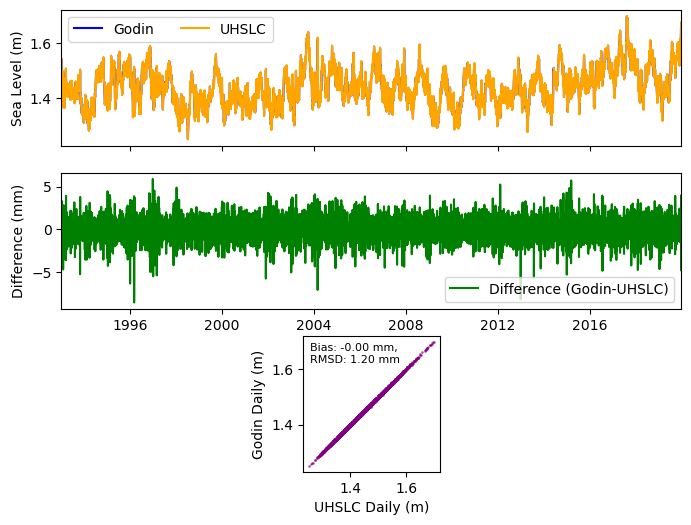

In [62]:
# compare the two datasets
rsl_uhslc_daily = rsl_uhslc_daily.sel(time=slice(start_date + pd.DateOffset(days=1), end_date - pd.DateOffset(days=1)))
rsl_uhslc_daily['sea_level_m'] = rsl_uhslc_daily['sea_level']/1000   # convert from mm to m


# truncate both datasets to end in 2019-12-31, start on 1993-01-02
daily_subset = daily.sel(time=slice('1993-01-02', '2019-12-31'))
rsl_uhslc_daily = rsl_uhslc_daily.sel(time=slice('1993-01-02', '2019-12-31'))


# make a figure with 3 rows and 1 column
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
fig,axs = plt.subplots(3,1,figsize=(8,6))
# first plot the full time series
axs[0].plot(daily_subset.sel(station_id='1612340').time, daily_subset.sel(station_id='1612340'), label='Godin', color='blue')
axs[0].plot(rsl_uhslc_daily.sel(station_id=570).time, rsl_uhslc_daily.sel(station_id=570).sea_level_m, label='UHSLC', color='orange')
axs[0].set_ylabel('Sea Level (m)')
axs[0].legend(ncol=2)
#remove xtick labels for the first plot
axs[0].set_xticklabels([])

# second plot the difference
axs[1].plot(daily_subset.sel(station_id='1612340').time, 1000*(daily_subset.sel(station_id='1612340') - rsl_uhslc_daily.sel(station_id=570).sea_level_m), label='Difference (Godin-UHSLC)', color='green')
axs[1].set_ylabel('Difference (mm)')
axs[1].legend()

for ax in axs[0:2]:
    ax.set_xlim(pd.to_datetime('1993-01-02'), pd.to_datetime('2019-12-31'))

# third plot the scatter plot
axs[2].scatter(rsl_uhslc_daily.sel(station_id=570).sea_level_m, daily_subset.sel(station_id='1612340'), color='purple', alpha=0.5,s=1)
axs[2].set_xlabel('UHSLC Daily (m)')
axs[2].set_ylabel('Godin Daily (m)')


# # add bias and rmsd to the plot
bias = (daily_subset.sel(station_id='1612340') - rsl_uhslc_daily.sel(station_id=570).sea_level_m).mean().values
rmsd = np.sqrt(((daily_subset.sel(station_id='1612340') - rsl_uhslc_daily.sel(station_id=570).sea_level_m)**2).mean()).values
axs[2].text(0.05, 0.95, f'Bias: {bias*1000:.2f} mm, \nRMSD: {rmsd*1000:.2f} mm', 
        transform=axs[2].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0))   

axs[2].set_aspect('equal', 'box')



### Normalize the tide gauge data relative to the 1993-2012 epoch

In [63]:

epoch_start, epoch_end = start_date, '2012-12-31'
epoch_daily_avg = daily.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean = epoch_daily_avg.mean(dim='time')



In [64]:
epoch_daily_mean_cmems = sla.sel(time=slice(epoch_start, epoch_end)).mean(dim='time')
epoch_daily_mean_cmems

<xarray.Dataset> Size: 2kB
Dimensions:       (station_id: 7)
Coordinates:
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sla           (station_id) float64 56B 0.02742 0.02545 ... 0.0248 0.02581
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    lat_str       (station_id) <U8 224B '19.688°N' '28.188°N' ... '21.938°N'
    lon_str       (station_id) <U9 252B '204.937°E' '182.687°E' ... '200.687°E'

In [65]:
epoch_daily_mean

<xarray.DataArray 'sea_level' (station_id: 7)> Size: 56B
array([1.56588692, 1.05545723, 1.07573474, 1.23038405, 1.0955599 ,
       1.42868934, 0.96387138])
Coordinates:
  * station_id  (station_id) <U7 196B '1617760' '1619910' ... '1611400'

In [66]:
# Display station names in a cleaner format
print("Station Names:")
for i, name in enumerate(rsl['station_name'].values):
    station_id = rsl['station_id'].values[i]
    print(f"{i}: {name} (Station ID: {station_id})")

Station Names:
0: Hilo, Hilo Bay, Kuhio Bay (Station ID: 1617760)
1: Sand Island, Midway Islands (Station ID: 1619910)
2: Kawaihae (Station ID: 1617433)
3: Mokuoloe (Station ID: 1612480)
4: Kahului, Kahului Harbor (Station ID: 1615680)
5: Honolulu (Station ID: 1612340)
6: Nawiliwili (Station ID: 1611400)


In [67]:
start_date

datetime.datetime(1993, 1, 1, 0, 0)

In [68]:
# Subtract the epoch daily mean from the tide gauge daily average
rsl_daily = daily - epoch_daily_mean

# add in the CMEMS mean for the epoch to remove bias from 1993 start.
rsl_daily = rsl_daily + epoch_daily_mean_cmems['sla']

# Set the attributes of the rsl_daily data
rsl_daily.attrs = tide_gauge_data_POR.attrs
rsl_daily.attrs['units'] = 'm'

# add lat and lon to the dataset
rsl_daily['lat'] = rsl['lat']
rsl_daily['lon'] = rsl['lon']

# add the station name and country
rsl_daily['station_name'] = rsl['station_name']

# change the variable name to sea level anomaly
rsl_daily.name = 'rsl_anomaly'

# change long name of the variable to sea level anomaly
rsl_daily.attrs['long_name'] = 'Sea Level Anomaly'
rsl_daily.attrs['epoch'] = '1993-2012'

rsl_daily

<xarray.DataArray 'rsl_anomaly' (station_id: 7, time: 11685)> Size: 654kB
array([[ 0.11869508,  0.11576306,  0.08987653, ...,  0.11208584,
         0.12709028,  0.1094798 ],
       [-0.01000402, -0.00017083, -0.01274826, ...,  0.13208022,
         0.07369855,  0.08371904],
       [        nan,         nan,         nan, ...,  0.1349193 ,
         0.1117684 ,  0.12608305],
       ...,
       [ 0.11647688,  0.10981098,  0.10000841, ...,  0.11599285,
         0.1120607 ,  0.10025938],
       [ 0.13851905,  0.12396106,  0.1101846 , ...,  0.0873078 ,
         0.08217557,  0.08461995],
       [ 0.10314668,  0.09284807,  0.0805205 , ...,  0.062133  ,
         0.05640342,  0.04414911]], shape=(7, 11685))
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 93kB 1993-01-02T12:00:00 ... 2024-12-...
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

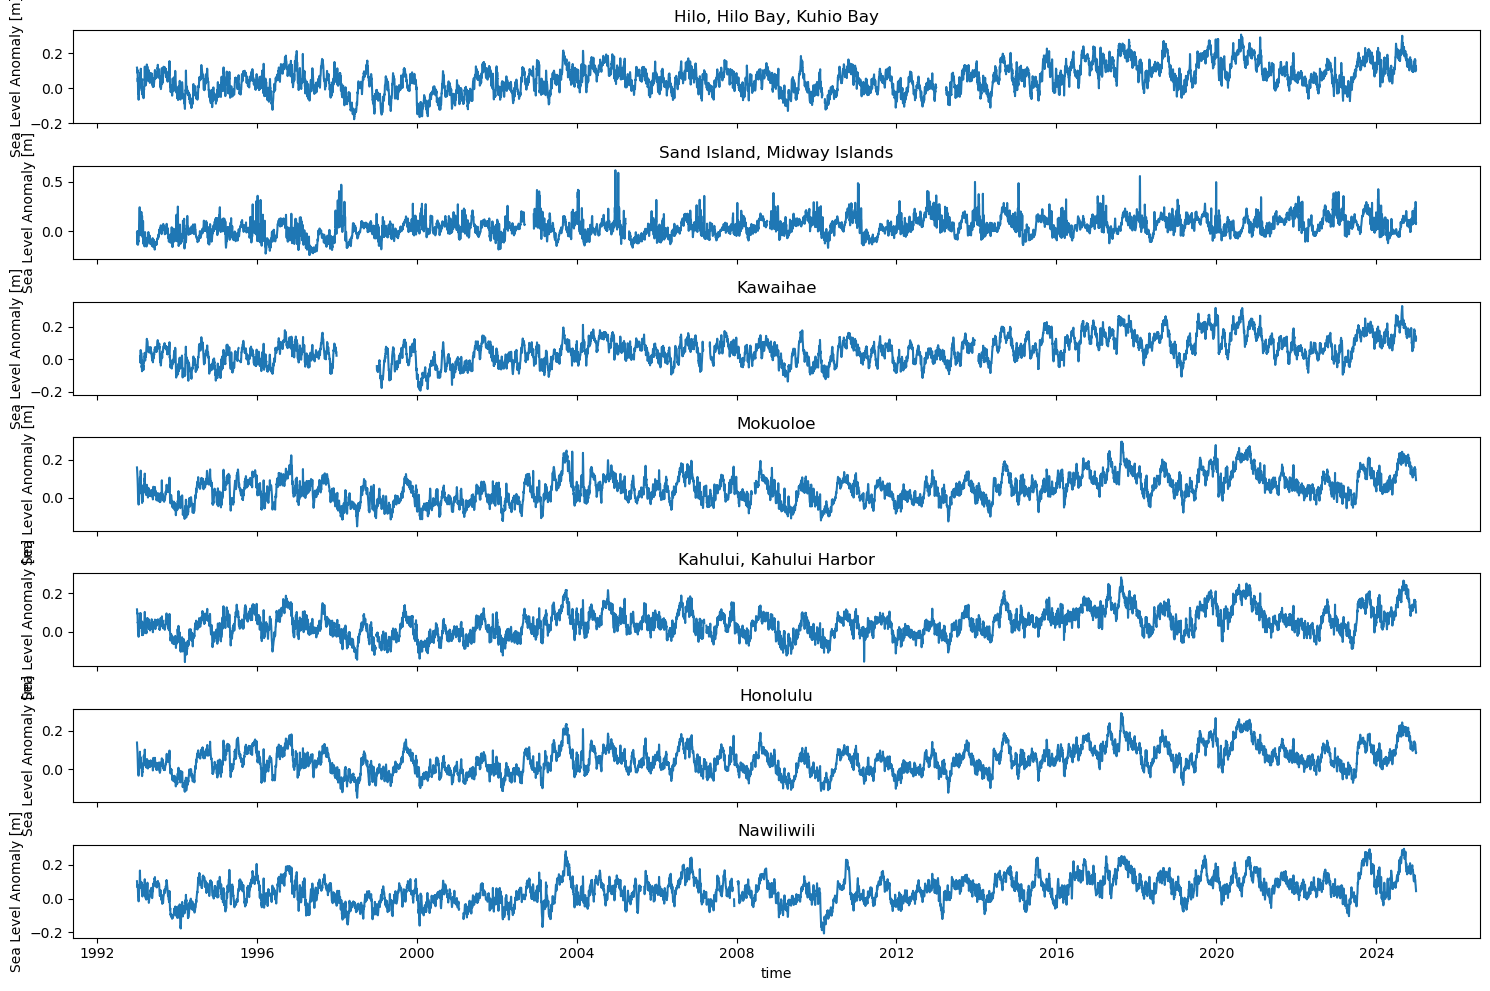

In [69]:
g = rsl_daily.plot(x='time', col='station_id', col_wrap=1, sharey=False, sharex=True, figsize=(15, 10))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, id in zip(g.axs.flat, rsl_daily.station_id):
    # Accessing the station_name coordinate for the current station_id directly
    station_name = rsl_daily.station_name.sel(station_id=id).item()
    ax.set_title(station_name)

plt.show()


In [70]:
stationdictNOAA

{'Nawiliwili': '1611400',
 'Honolulu': '1612340',
 'Mokuoloe': '1612480',
 'Kahului, Kahului Harbor': '1615680',
 'Kawaihae': '1617433',
 'Hilo, Hilo Bay, Kuhio Bay': '1617760',
 'Sand Island, Midway Islands': '1619910'}

In [72]:
# Set tide gauge daily average relative to MHHW
rsl_daily_mhhw = daily - rsl['MHHW']

# Set the attributes of the rsl_daily data
rsl_daily_mhhw.attrs = tide_gauge_data_POR.attrs
rsl_daily_mhhw.attrs['long_name'] = 'water level above MHHW'
rsl_daily_mhhw.attrs['units'] = 'm'
# add lat and lon to the dataset
rsl_daily_mhhw['lat'] = rsl['lat']
rsl_daily_mhhw['lon'] = rsl['lon']
# add the station name and country
rsl_daily_mhhw['station_name'] = rsl['station_name']

rsl_daily_mhhw.name = 'rsl_mhhw'
# save rsl_daily to the data directory
# rsl_daily_mhhw.to_netcdf(data_dir / 'rsl_daily_hawaii_mhhw.nc')


#combine the two datasets
rsl_daily_combined = xr.merge([rsl_daily, rsl_daily_mhhw])

rsl_daily_combined['storm_time'] = rsl_daily_combined['time']
rsl_daily_combined['storm_time'] = xr.DataArray(
    pd.to_datetime(rsl_daily_combined['storm_time'].values).to_series().apply(
        lambda x: x if x.month >= 5 else x - pd.DateOffset(years=1)
    ),
    dims=rsl_daily_combined['storm_time'].dims,
    coords=rsl_daily_combined['storm_time'].coords
)

#make storm time a coordinate
rsl_daily_combined = rsl_daily_combined.assign_coords(storm_time = rsl_daily_combined.storm_time, compat='no_conflicts')

# save rsl_daily_combined to the data directory
rsl_daily_combined.to_netcdf(data_dir / 'rsl_daily_hawaii.nc')

/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_206/2544893247.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  rsl_daily_combined = xr.merge([rsl_daily, rsl_daily_mhhw])
/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_206/2544893247.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  rsl_daily_combined = xr

In [73]:
rsl_daily_combined

<xarray.Dataset> Size: 1MB
Dimensions:       (station_id: 7, time: 11685)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 93kB 1993-01-02T12:00:00 ... 2024-12-...
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    storm_time    (time) datetime64[ns] 93kB 1992-01-02T12:00:00 ... 2024-12-...
    compat        <U12 48B 'no_conflicts'
Data variables:
    rsl_anomaly   (station_id, time) float64 654kB 0.1187 0.1158 ... 0.04415
    rsl_mhhw      (station_id, time) float64 654kB -0.2698 -0.2728 ... -0.2728
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [74]:
#what's the mean sla_tg anomaly from 1993-2012
sla_mean = sla.sel(time=slice('1993-01-01', '2012-12-31')).mean(dim='time')
sla_mean


<xarray.Dataset> Size: 2kB
Dimensions:       (station_id: 7)
Coordinates:
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sla           (station_id) float64 56B 0.02742 0.02545 ... 0.0248 0.02581
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    lat_str       (station_id) <U8 224B '19.688°N' '28.188°N' ... '21.938°N'
    lon_str       (station_id) <U9 252B '204.937°E' '182.687°E' ... '200.687°E'

In [75]:
# rsl_daily_combined['storm_time'] = rsl_daily_combined['time']
# rsl_daily_combined['storm_time'] = xr.DataArray(
#     pd.to_datetime(rsl_daily_combined['storm_time'].values).to_series().apply(
#         lambda x: x if x.month >= 5 else x - pd.DateOffset(years=1)
#     ),
#     dims=rsl_daily_combined['storm_time'].dims,
#     coords=rsl_daily_combined['storm_time'].coords
# )

# #make storm time a coordinate
# rsl_daily_combined = rsl_daily_combined.assign_coords(storm_time = rsl_daily_combined.storm_time)

# # save rsl_daily_combined to the data directory
# rsl_daily_combined.to_netcdf(data_dir / 'rsl_daily_hawaii.nc')

# rsl_daily_combined


## Retrieve Climate Indices
```{figure} https://raw.githubusercontent.com/jwfiedler/SL_Hawaii/refs/heads/main/icons/SERDP_Figure_2.10.png
---
width: 300px
name: SERDP_fig
align: right
---
<small> Geographical extent of climate indices considered in previous research. <br>(Marra, J.J. et al., 2023)</small>
```

Here, we'll retrieve climate indices to compare sea levels to co-occurring processes in the global ocean and atmosphere. These indices will later be used for our nonstationary extreme sea level analysis, as well as a general comparison. For the Hawaii region, we'll look at the following indices that were also used in {cite:t}`marra_advancing_2023`:

1. **PMM: Pacific Meridional Mode** This index describes the meridional variability of sea surface temperature and wind in the tropical Pacific Ocean {cite:p}`chiang_analogous_2004`. It is the leading mode of non-ENSO variability in the Pacific. For more information, see the [PSL PMM](https://psl.noaa.gov/data/timeseries/month/DS/PMM/) page or the [PMM page](https://www.aos.wisc.edu/dvimont/MModes/PMM.html) from University of Wisconson. 

2. **PDO: Pacific Decadal Oscillation** This index describes the monthly SST anomalies in the North Pacific Ocean {cite:p}`newman_pacific_2016`. See the [PSL PDO](https://psl.noaa.gov/pdo/) page for more information.

3. **BEST: Bivariate EnSo Timeseries** This climate index combines the atmospheric component of ENSO (SOI) with the oceanic component (Nino 3.4 SST) {cite:p}`smith_effect_2000`. See the [PSL BEST](https://psl.noaa.gov/data/timeseries/month/BEST/) page for more information. 

4. **ONI: Oceanic Niño Index** This is the official NOAA index for the state of ENSO, looking at the 3-month running mean of SST anomalies in the Niño 3.4 region {cite:p}`bamston_documentation_1997`. For more info, visit the [PSL ENSO](https://psl.noaa.gov/enso/) page.  

5. **TNA: Tropical North Atlantic Index** This is the monthly anomaly of the SST in the eastern tropical Atlantic. For more info, see the [TNA page](https://psl.noaa.gov/data/timeseries/month/DS/TNA/).

6. **PNA: Pacific North American Index** This index describes the variability in atmospheric circulation from the East Asian jet stream to identify patterns in the North Pacific. See the [PNA page](https://psl.noaa.gov/data/timeseries/month/DS/PNA/) for more info.

7. **AO: Arctic Oscillation** This is a measure of the strength of the sea level pressure within the Arctic circle. Visit PSL's [AO page](https://psl.noaa.gov/data/timeseries/month/DS/AO/) for more info.



In [76]:
def read_psl_url(url):
    response = requests.get(url)
    data = response.text
    # Split the data into lines
    lines = data.strip().split('\n')
    # Collect data lines until we encounter -9999
    data_lines = []
    for line in lines[1:]:  # Skip the first line if it's a header
        stripped_line = line.strip()
        if stripped_line == '':
            continue  # Skip empty lines
        # Detect possible footer lines (either starting with -99.9, -9999, or a textual footer)
        if stripped_line.startswith('-99.9') or stripped_line.startswith('-99.99') or stripped_line.startswith('-9999') or any(char.isalpha() for char in stripped_line):
            break  # Stop processing when footer is encountered
        # Add valid data lines to the list
        data_lines.append(line)
    # Combine data lines into a single string
    data_str = '\n'.join(data_lines)
    data_io = io.StringIO(data_str)
    return data_io

In [77]:
def read_psl_format(csvfile, varName):
    df = pd.read_csv(csvfile, sep=r'\s+', skiprows=1, skipfooter=0, header=None, engine='python')
    CI = df.melt(id_vars=0, var_name='Month', value_name=varName)
    #Replace placeholder values with NaN
    CI.replace([-9.99, -9999, -9999.000, -999.99,-99.90,-99.99], np.nan, inplace=True)
    # Drop rows with NaN values
    CI = CI.dropna(subset=[varName])
    CI['time'] = pd.to_datetime({'year': CI[0], 'month': CI['Month'], 'day': 1})
    # Sort by 'time'
    CI = CI.sort_values('time').reset_index(drop=True)
    CI = CI[['time', varName]]

    return CI

In [78]:
def read_ncei_format(csvfile, varName):
    df = pd.read_csv(csvfile, sep=r'\s+', skiprows=0, skipfooter = 0,header=1, engine='python')
    ClimateIndex = df.melt(id_vars='Year', var_name='Month', value_name=varName)
    ClimateIndex['Month'] = ClimateIndex['Month'].map(month_mapping)
    # Replace placeholder values with NaN
    ClimateIndex.replace(99.99, np.nan, inplace=True)
    # Drop rows with NaN values
    ClimateIndex = ClimateIndex.dropna(subset=[varName])
    ClimateIndex['time'] = pd.to_datetime({'year': ClimateIndex['Year'], 'month': ClimateIndex['Month'], 'day': 1})
    # Sort by 'time'
    ClimateIndex = ClimateIndex.sort_values('time').reset_index(drop=True)
    ClimateIndex = ClimateIndex[['time', varName]]
    return ClimateIndex

In [79]:
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov':11, 'Dec':12
}

In [80]:
# Function to convert fraction of the year to datetime
def convert_fraction_to_date(date_float):
    # Extract year and fraction
    year = int(date_float)
    fraction = date_float - year
    
    # Calculate the total number of days in the year (consider leap years)
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    
    # Calculate the day of the year based on the fraction
    day_of_year = int(np.floor(fraction * days_in_year)) + 1
    
    # Create a datetime object for January 1st of the given year
    start_date = pd.to_datetime(f"{year}-01-01")
    
    # Add the day offset to get the actual date
    return start_date + pd.to_timedelta(day_of_year - 1, unit='D')

In [81]:
def retrieve_pdo_ncei(data_dir=data_dir):
    url = 'https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat'
    response = requests.get(url)
    data = response.text
    data_io = io.StringIO(data)
    PDO = read_psl_format(data_io, 'PDO')
    PDO.to_csv(data_dir / 'pdo.csv', index=False)
    print('PDO data retrieved and saved to data directory')

    return PDO


In [82]:
def retrieve_climateIndex(ClimateIndex, data_dir=data_dir):
    PSLurlBase = 'https://psl.noaa.gov/data/'

    # Define the URL based on the ClimateIndex
    if ClimateIndex in ['TNA', 'ONI','PNA']:
        url = PSLurlBase + 'correlation/' + ClimateIndex.lower() + '.data'
    
    elif ClimateIndex in ['AAO','PMM']:
        url = PSLurlBase + 'timeseries/month/data/' + ClimateIndex.lower() + '.data'

    elif ClimateIndex == 'AO':
        url = PSLurlBase + 'timeseries/month/data/' + ClimateIndex.lower() + '.long.data'

    elif ClimateIndex == 'DMI':
        url = 'https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/dmieast.had.long.data'

    elif ClimateIndex == 'BEST':
        url = PSLurlBase + 'correlation/censo.data'
    
    elif ClimateIndex == 'PDO':
        url = 'https://psl.noaa.gov/pdo/data/pdo.timeseries.sstens.data'

    else:
        raise ValueError(f"ClimateIndex '{ClimateIndex}' is not recognized")
    
    print(f"Retrieving data from: {url}")

    # Fetch and format the data
    data_io = read_psl_url(url)
    climate_data = read_psl_format(data_io, ClimateIndex)

    # Save the data to a CSV file
    output_file = data_dir / 'climate_indices' / (ClimateIndex.lower() + '.csv')
    climate_data.to_csv(output_file, index=False)
    print(f"{ClimateIndex} data retrieved and saved to {output_file}")

    return climate_data

In [83]:
ONI = retrieve_climateIndex('ONI')
TNA = retrieve_climateIndex('TNA')
PNA = retrieve_climateIndex('PNA')
# AAO = retrieve_climateIndex('AAO')
AO = retrieve_climateIndex('AO')
# DMI = retrieve_climateIndex('DMI')
BEST = retrieve_climateIndex('BEST')

PDO = retrieve_climateIndex('PDO')

PMM = retrieve_climateIndex('PMM')

Retrieving data from: https://psl.noaa.gov/data/correlation/oni.data
ONI data retrieved and saved to /Users/jfiedler/Projects/SL_Indicators/data/climate_indices/oni.csv
Retrieving data from: https://psl.noaa.gov/data/correlation/tna.data
TNA data retrieved and saved to /Users/jfiedler/Projects/SL_Indicators/data/climate_indices/tna.csv
Retrieving data from: https://psl.noaa.gov/data/correlation/pna.data
PNA data retrieved and saved to /Users/jfiedler/Projects/SL_Indicators/data/climate_indices/pna.csv
Retrieving data from: https://psl.noaa.gov/data/timeseries/month/data/ao.long.data
AO data retrieved and saved to /Users/jfiedler/Projects/SL_Indicators/data/climate_indices/ao.csv
Retrieving data from: https://psl.noaa.gov/data/correlation/censo.data
BEST data retrieved and saved to /Users/jfiedler/Projects/SL_Indicators/data/climate_indices/best.csv
Retrieving data from: https://psl.noaa.gov/pdo/data/pdo.timeseries.sstens.data
PDO data retrieved and saved to /Users/jfiedler/Projects/SL_

In [84]:
# List of all DataFrames and their corresponding names
CIs = {
    'BEST': BEST,
    # 'DMI': DMI,
    'AO': AO,
    # 'AAO': AAO,
    'PNA': PNA,
    'TNA': TNA,
    'ONI': ONI,
    'PDO': PDO,
    'PMM': PMM
}

# Start with the first DataFrame (BEST in this case)
merged_CI = CIs['BEST']

# Loop through the rest of the DataFrames and merge them on 'time'
for name, df in CIs.items():
    if name != 'BEST':
        merged_CI = pd.merge(merged_CI, df, on='time', how='outer')



In [85]:
# truncate to 1990 through 2024
merged_CI = merged_CI[(merged_CI['time'] >= '1990-01-01') & (merged_CI['time'] <= '2024-12-31')]

#replace placeholder values with NaN
merged_CI.replace([-999], np.nan, inplace=True)

merged_CI.to_csv(data_dir / 'climate_indices' / 'climate_indices.csv', index=False)


In [86]:
# get standard deviation of the climate indices
merged_CI = pd.read_csv(data_dir / 'climate_indices' / 'climate_indices.csv')

# Calculate the standard deviation of each column except 'time'
std_dev = merged_CI.drop(columns='time').std()

# calculate the mean of each column except 'time'
mean = merged_CI.drop(columns='time').mean()

In [87]:
mean

BEST    0.090238
AO      0.059340
PNA    -0.014190
TNA     0.317690
ONI     0.010548
PDO    -0.434314
PMM     0.102714
dtype: float64

In [88]:
# normalize the climate indices such that they have a standard deviation of 1
merged_CI_norm = merged_CI.copy()
for col in merged_CI_norm.columns[1:]:
    # normalize the column by subtracting the mean and dividing by the standard deviation
    merged_CI_norm[col] = merged_CI_norm[col] - mean[col]
    merged_CI_norm[col] = merged_CI_norm[col] / std_dev[col]

merged_CI_norm['time'] = pd.to_datetime(merged_CI_norm['time'])

#save to the data directory
merged_CI_norm.to_csv(data_dir / 'climate_indices' / 'climate_indices_norm.csv', index=False)

    

In [89]:
merged_CI_norm

,time,BEST,AO,PNA,TNA,ONI,PDO,PMM
0,1990-01-01,0.086908,0.939548,-1.126112,-1.004769,0.151373,0.110990,0.504310
1,1990-02-01,0.861475,3.335166,-2.895133,-1.055300,0.233226,-0.425292,-0.069556
2,1990-03-01,0.522602,2.924089,0.056724,-0.903709,0.315079,-0.315495,0.507299
3,1990-04-01,0.232139,1.815580,-0.634136,-0.651058,0.326772,0.473955,0.498333
4,1990-05-01,-0.368150,0.881678,0.297479,-0.474202,0.326772,0.397732,0.333944
...,...,...,...,...,...,...,...,...
415,2024-08-01,-0.697341,1.221914,-1.073774,2.052309,-0.140960,-1.405298,0.794232
416,2024-09-01,0.019134,-0.681809,1.145353,1.824923,-0.257893,-2.110358,0.770321
417,2024-10-01,-0.542427,0.464616,0.224206,1.799658,-0.316360,-2.414341,0.363833
418,2024-11-01,-0.455288,-0.096124,0.067192,1.673332,-0.444986,-2.219248,0.097822


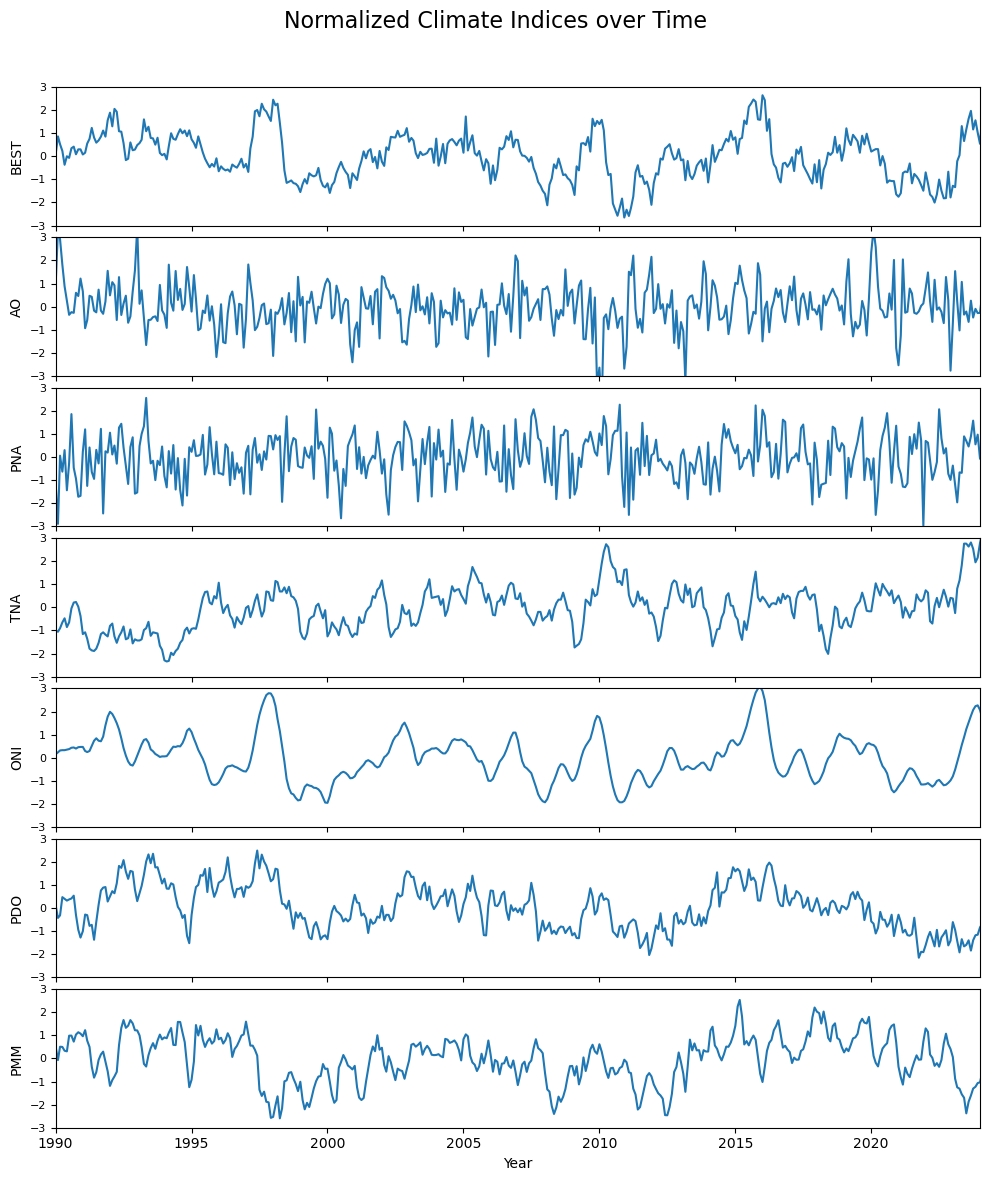

In [90]:
import matplotlib.dates as mdates

indices = merged_CI_norm.columns[1:]

# Adjusting the x-axis limits to range from 1993 to 2024
fig, axs = plt.subplots(len(indices), 1, figsize=(10, 12), sharex=True)

# Loop through each index and its corresponding subplot
for i, index in enumerate(indices):
    axs[i].plot(merged_CI_norm['time'], merged_CI_norm[index], label=index)
    axs[i].set_ylabel(index)  
    axs[i].set_ylim(-3, 3)  # Set y-axis limits to
    axs[i].tick_params(axis='y', labelsize=8)  # Set smaller tick size for y-axis

# Set the x-axis label only for the last subplot
axs[-1].set_xlabel('Year')

# Set x-axis major ticks to every 5 years and limit to 1993 to 2024
axs[-1].set_xlim(pd.Timestamp('1990-01-01'), pd.Timestamp('2024-01-01'))
axs[-1].xaxis.set_major_locator(mdates.YearLocator(5))
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set a common title for the figure
fig.suptitle('Normalized Climate Indices over Time', fontsize=16)

# Adjust spacing between subplots, reducing vertical gaps
plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=0.5)




Let's also make a csv for ONI that has a boolean Niño/Niña flag. An official event is one that has persisted for longer than 5 months, so we'll update our flag to reflect that.


In [91]:
ONI['La Nina'] = ONI['ONI'].apply(lambda x: 1 if x <= -0.5 else 0)
ONI['El Nino'] = ONI['ONI'].apply(lambda x: 1 if x >= 0.5 else 0)

# Now make sure that La Nina and El Nino events last for at least 5 consecutive months,
# set ONI['La Nina'] and ONI['El Nino'] to 0 if they don't last for at least 5 months
ONI['La Nina'] = (ONI['La Nina'].groupby((ONI['La Nina'] != ONI['La Nina'].shift()).cumsum())
                 .transform(lambda x: x if x.sum() >= 5 else 0))
ONI['El Nino'] = (ONI['El Nino'].groupby((ONI['El Nino'] != ONI['El Nino'].shift()).cumsum())
                 .transform(lambda x: x if x.sum() >= 5 else 0))

#save ONI as oni_bool.csv to CI_dir
ONI.to_csv(data_dir / 'climate_indices' / 'oni_bool.csv')

---

## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```